In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from scipy.stats import poisson
import seaborn as sns
import sklearn.neighbors
import matplotlib.pyplot as plt
%matplotlib inline

import Levenshtein

import sys
sys.path.append('..')
from lib import *

plt.style.use('../peptidome.mplstyle')

In [2]:
df_t = load_iedb_tcellepitopes()

In [3]:
S = 20
k = 9

Ntot = S**k
Nn = k*(S-1)

In [4]:
counter9 = count_kmers_proteome(human, k, clean=True)
human9 = set(counter9)
Nhuman = len(human9)

In [5]:
Nhuman/sum(counter9.values())

0.9165020031878309

In [6]:
counterm9 = count_kmers_proteome(proteome_path('Mouse'), k, clean=True)
mouse9 = set(counterm9)

In [7]:
df_t['Host', 'Name'].value_counts()

Homo sapiens                                                    208781
Mus musculus C57BL/6                                             29792
Mus musculus BALB/c                                              20713
Mus musculus                                                      5414
Homo sapiens Caucasian                                            3969
                                                                 ...  
Mus musculus BALB/c X B10.BR                                         1
Mus musculus MBP121-150 TCR Tg&nbsp;                                 1
Mus musculus B6.129S2-Cd28tm1Mak                                     1
Mus musculus C57BL/6 HLA-B27 Tg human beta2m Tg human CD8 Tg         1
Mus musculus CBA X AKR                                               1
Name: (Host, Name), Length: 587, dtype: int64

In [8]:
np.sum(df_t['Host', 'Name'].str.contains('Mus musculus', na=False)), np.sum(df_t['Host', 'Name'].str.contains('Homo sapiens', na=False))

(104748, 212825)

In [9]:
# only human hosts
mask = df_t['Host', 'Name'].str.contains('Homo sapiens', na=False)
# no human epitopes or epitopes of unknown provenance
mask &= ~df_t['Epitope', 'Parent Species'].str.contains('Homo sapiens', na=True)
# only epitopes of length 9
mask &= df_t['Epitope', 'Description'].apply(len)==9
d = df_t[mask]
d['1st in vivo Process', 'Process Type'].value_counts()

Administration in vivo                                                             15122
Occurrence of infectious disease                                                    5965
Exposure with existing immune reactivity without evidence for disease               3684
Environmental exposure to endemic/ubiquitous agent without evidence for disease     2664
No immunization                                                                      994
Documented exposure without evidence for disease                                     244
Exposure without evidence for disease                                                147
Occurrence of autoimmune disease                                                      94
Occurrence of cancer                                                                  89
Occurrence of allergy                                                                 55
Occurrence of disease                                                                 24
Unknown              

In [10]:
mask = df_t['Host', 'Name'].str.contains('Mus musculus', na=False)
df_t[mask]['Epitope', 'Parent Species'].value_counts().head()

Mus musculus                                   11569
Vaccinia virus                                  9686
Homo sapiens                                    9411
Influenza A virus                               6885
Lymphocytic choriomeningitis mammarenavirus     5211
Name: (Epitope, Parent Species), dtype: int64

## Response frequency as a function of distance

In [11]:
host = 'Homo sapiens'
exclude = host
selfset = human9

In [12]:
#host = 'Mus musculus C57BL/6'
#exclude = 'Mus musculus'
#selfset = mouse9

In [13]:
# only specified hosts
mask = df_t['Host', 'Name'].str.contains(host, na=False)
#mask &= ~df_t['Host', 'Name'].str.contains('HLA', na=False)
# only epitopes of length 9
mask &= df_t['Epitope', 'Description'].apply(len)==9
# no host epitopes or epitopes of unknown provenance
mask &= ~df_t['Epitope', 'Parent Species'].str.contains(exclude, na=True)
d = df_t[mask]

In [14]:
dg = d.groupby(('Epitope', 'Description'))

In [15]:
d.columns = [' '.join(col).strip() for col in d.columns.values]

In [16]:
d['Assay Qualitative Measure'] = d['Assay Qualitative Measure'] == 'Negative'

<ipython-input-16-34b64c3fd5f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['Assay Qualitative Measure'] = d['Assay Qualitative Measure'] == 'Negative'


In [17]:
dfaq = d.groupby('Epitope Description')['Assay Qualitative Measure'].mean()

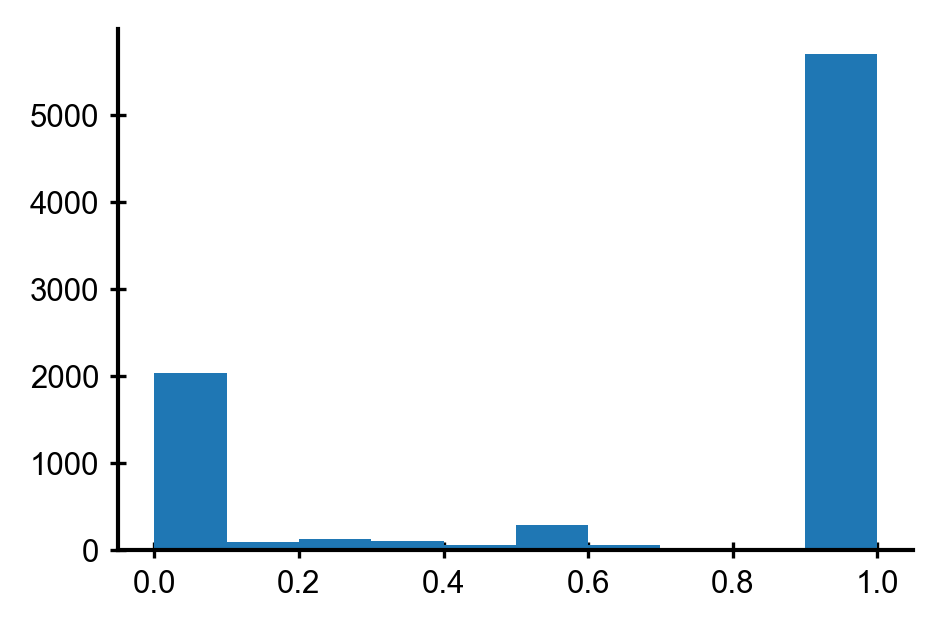

In [18]:
plt.hist(dfaq);

In [19]:
d = df_t
d[d[('Epitope', 'Description')]=='NLVPMVATV'][('Assay', 'Qualitative Measure')].value_counts()

Positive         613
Negative          17
Positive-Low      14
Positive-High      5
Name: (Assay, Qualitative Measure), dtype: int64

(array([0.0000e+00, 0.0000e+00, 4.0000e+00, 4.0000e+00, 1.9000e+01,
        6.3000e+01, 2.2700e+02, 2.0900e+02, 7.8460e+03, 5.4533e+04,
        2.3512e+04, 4.5010e+03, 7.8370e+03, 5.9380e+03, 4.6470e+03,
        1.3057e+05, 9.9990e+03, 9.5870e+03, 1.2688e+04, 3.7220e+03,
        4.5307e+04, 3.4600e+03, 1.2440e+03, 9.5000e+02, 1.0110e+03,
        1.5280e+03, 5.5100e+02, 5.4800e+02, 4.8600e+02]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <BarContainer object of 29 artists>)

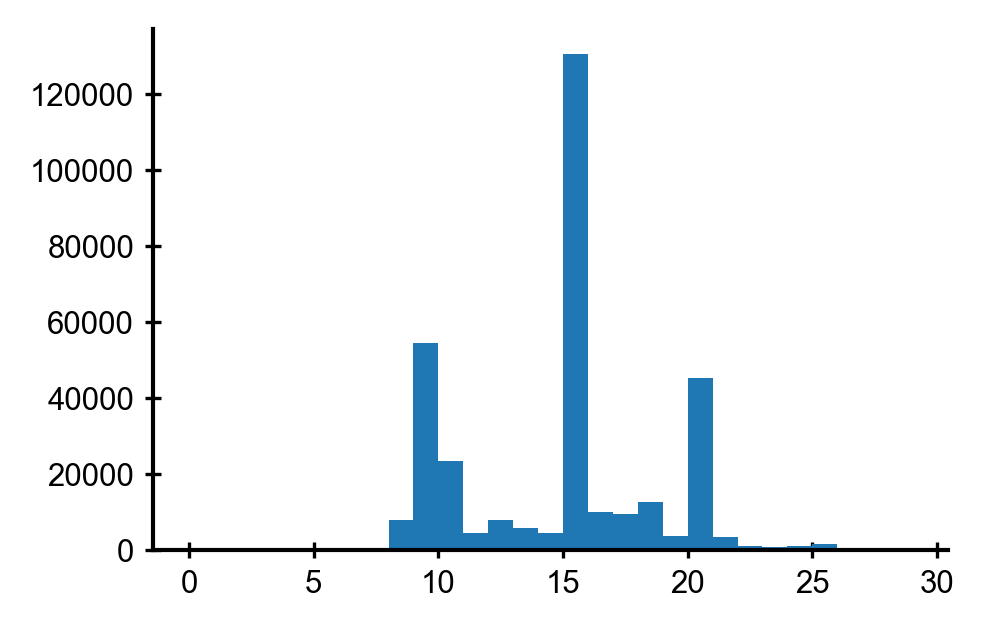

In [20]:
plt.hist(df_t['Epitope', 'Description'].apply(len), np.arange(0, 30, 1))

In [21]:
# only specified hosts
mask = df_t['Host', 'Name'].str.match(host, na=False)
# only epitopes of length 9
mask &= df_t['Epitope', 'Description'].apply(len)==9
# no host epitopes or epitopes of unknown provenance
mask &= ~df_t['Epitope', 'Parent Species'].str.contains(exclude, na=True)
# exclude autoimmune epitopes
mask &= ~(df_t['1st in vivo Process', 'Process Type'] == 'Occurrence of autoimmune disease')
mask &= df_t['Assay', 'Method/Technique'] == 'ELISPOT'
d = df_t[mask]
# uniquify epitopes by keeping only the first one
#d = d.groupby(('Epitope', 'Description')).apply(lambda x: x.iloc[0])

In [22]:
# uniquify epitopes by keeping only the most frequent qualitative measure
def most_frequent(x):
    counts = x.value_counts(dropna=False)
    if len(counts):
        return counts.index[0]
    else:
        print(x, counts)
    return np.nan
d = d[[('Epitope', 'Description'), ('Assay', 'Qualitative Measure')]].groupby(('Epitope', 'Description')).agg(most_frequent)
d = d.reset_index()

(array([2544.,  573., 1172., 2168.,  101.,   83.,   22.,    3.,    0.,
           5.]),
 array([0.        , 0.17923917, 0.35847834, 0.53771751, 0.71695668,
        0.89619584, 1.07543501, 1.25467418, 1.43391335, 1.61315252,
        1.79239169]),
 <BarContainer object of 10 artists>)

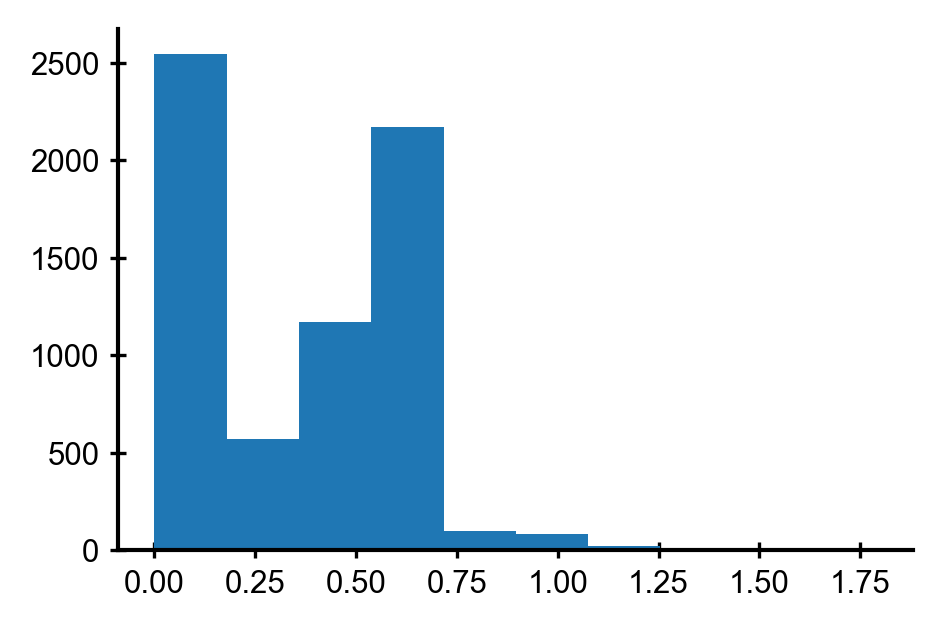

In [23]:
plt.hist(np.log10(df_t[mask][('Epitope', 'Description')].value_counts()))

In [24]:
d0 = d['Epitope', 'Description'].apply(lambda x: x in selfset)
count0 = np.sum(d0)
d1 = d['Epitope', 'Description'].apply(lambda x: dist1(x, selfset)) & (~d0)
count1 = np.sum(d1)
d2 = d['Epitope', 'Description'].apply(lambda x: dist2(x, selfset)) & (~d0) & (~d1)
count2 = np.sum(d2)
pos0 = d[d0][~(d[d0]['Assay', 'Qualitative Measure'] == 'Negative')].shape[0]
pos1 = d[d1][~(d[d1]['Assay', 'Qualitative Measure'] == 'Negative')].shape[0]
pos2 = d[d2][~(d[d2]['Assay', 'Qualitative Measure'] == 'Negative')].shape[0]
posall = d[(~(d['Assay', 'Qualitative Measure'] == 'Negative')) & (~d0) & (~d1) & (~d2)].shape[0]
ns = np.array([count0, count1, count2, d.shape[0]-count0-count1-count2])
ps = np.array([pos0, pos1, pos2, posall])/ns
ns, ps

(array([  33,  120, 2734, 3784]),
 array([0.03030303, 0.24166667, 0.23811266, 0.19212474]))

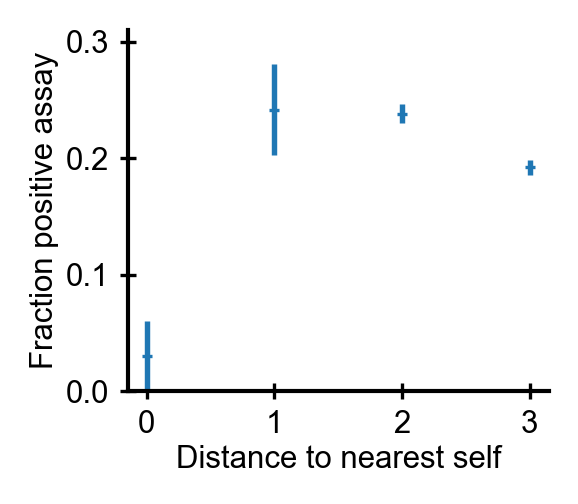

In [46]:
fig, ax = plt.subplots(figsize=(2.0, 1.75))
ax.errorbar(range(4), ps, (ps*(1-ps)/ns)**.5, ls='None', fmt='_')
ax.set_ylim(0, 0.31)
ax.set_xlabel('Distance to nearest self')
ax.set_ylabel('Fraction positive assay')
fig.tight_layout()
fig.savefig('main.png' if exclude == 'Homo sapiens' else exclude + '.png')
fig.savefig('iedbposvsdist.svg')

In [26]:
df_t['Assay', 'Method/Technique'].value_counts()

ELISPOT                            186787
3H-thymidine                        52891
ELISA                               24914
ICS                                 21974
51 chromium                         12045
multimer/tetramer                   10776
in vivo assay                        6477
cytometric bead array                3750
biological activity                  3685
bioassay                             3670
in vitro assay                       1968
binding assay                         944
CFSE                                  898
surface plasmon resonance (SPR)       763
RNA/DNA detection                     588
in vivo skin test                     514
BrdU                                  490
intracellular staining                451
x-ray crystallography                 181
reporter gene assay                    88
radio immuno assay (RIA)               84
any method                              7
Name: (Assay, Method/Technique), dtype: int64

In [27]:
df_t['Assay', 'Nonnegative'] = ~(df_t['Assay', 'Qualitative Measure'] == 'Negative')

In [28]:
df_t[[('Assay', 'Method/Technique'), ('Assay', 'Nonnegative')]].groupby(('Assay', 'Method/Technique')).agg(np.mean)

,Assay
,Nonnegative
"(Assay, Method/Technique)",
3H-thymidine,0.524210
51 chromium,0.670237
BrdU,0.618367
CFSE,0.788419
ELISA,0.524163
ELISPOT,0.232404
ICS,0.498771
RNA/DNA detection,0.685374


In [29]:
epitopes = d[d0][~(d[d0]['Assay', 'Qualitative Measure'] == 'Negative')]['Epitope', 'Description']
df_t[df_t['Epitope', 'Description'].isin(epitopes)]['Assay', 'Method/Technique'].value_counts()

ELISPOT    2
Name: (Assay, Method/Technique), dtype: int64

In [30]:
epitopes = d[d0]['Epitope', 'Description']
df_t[df_t['Epitope', 'Description'].isin(epitopes)]['Assay', 'Method/Technique'].value_counts()

ELISPOT    92
Name: (Assay, Method/Technique), dtype: int64

## Nearest neighbor frequencies using human statistics

In [30]:
df = Counter(human, 1).to_df(norm=True, clean=True)
pi = np.asarray(df['freq'])

psigmas = []
nsigmas = []
Nsample = 1000000
for i in range(Nsample):
    sigma = np.random.randint(0, S, k)
    psigma = np.prod(pi[sigma])
    nsigma = np.prod(pi[sigma])*(np.sum(1/pi[sigma]) - k)
    psigmas.append(psigma)
    nsigmas.append(nsigma)
nsigmas = np.asarray(nsigmas)
psigmas = np.asarray(psigmas)

p0 = 1/Ntot
pp = Ntot*np.mean(psigmas**2)
print(pp, p0)
n0 = Nn/Ntot
n = Ntot*np.mean(psigmas*nsigmas)
print(n0, n)

NameError: name 'fasta_iter' is not defined

In [ ]:
tripletparams = calc_tripletmodelparams(human)

In [ ]:
ptri = lambda seq: 10**loglikelihood_triplet(map_numbertoaa(seq), **tripletparams)


In [ ]:
psigmas = []
Nsample = 1000000
for i in range(Nsample):
    sigma = np.random.randint(0, S, k)
    psigma = ptri(sigma)
    psigmas.append(psigma)
    nsigma = np.prod(pi[sigma])*(np.sum(1/pi[sigma]) - k)
psigmas = np.asarray(psigmas)

pptri = Ntot*np.mean(psigmas**2)
pptri

In [ ]:
def neighbors(sigma, S):
    for i in range(len(sigma)):
        for s in range(S):
            if not sigma[i] == s:
                yield np.asarray(list(sigma[:i]) + [s] + list(sigma[i+1:]))

In [ ]:
psigmas = []
nsigmas = []
Nsample = 10000
for i in range(Nsample):
    sigma = np.random.randint(0, S, k)
    psigma = ptri(sigma)
    nsigma = np.sum(np.fromiter((ptri(sigmap) for sigmap in neighbors(sigma, S)), np.float))
    psigmas.append(psigma)
    nsigmas.append(nsigma)
psigmas = np.asarray(psigmas)
nsigmas = np.asarray(nsigmas)

pptri = Ntot*np.mean(psigmas**2)
ntri = Ntot*np.mean(psigmas*nsigmas)
print(pptri, ntri/Nn)

In [31]:
# only human hosts
mask = df_t['Host', 'Name'].str.contains('Homo sapiens', na=False)
# no epitopes of unknown provenance
mask &= ~df_t['Epitope', 'Parent Species'].isna()
# only epitopes of length 9
mask &= df_t['Epitope', 'Description'].apply(len)==9

mask_noh = mask[:]
mask_noh &= ~df_t['Epitope', 'Parent Species'].str.contains('Homo sapiens', na=True)
mask1 = mask_noh[:]
mask1 &= ~(df_t['Assay', 'Qualitative Measure'] == 'Negative')
mask2 = mask_noh[:]
mask2 &= df_t['Assay', 'Qualitative Measure'] == 'Negative'

mask_noh &= ~(df_t['Assay', 'Qualitative Measure'] == 'Negative')
mask3 = mask_noh[:]
mask3 &= df_t['1st in vivo Process', 'Process Type'] == 'Occurrence of infectious disease'
mask4 = mask_noh[:]
mask4 &= df_t['1st in vivo Process', 'Process Type'] == 'Occurrence of allergy'
mask5 = mask.copy()
mask5 &= ~(df_t['Assay', 'Qualitative Measure'] == 'Negative')
mask5 &= df_t['1st in vivo Process', 'Process Type'] == 'Occurrence of autoimmune disease'
mask5 &= df_t['Epitope', 'Parent Species'].str.contains('Homo sapiens', na=False)
mask6 = mask[:]
mask6 &= ~(df_t['Assay', 'Qualitative Measure'] == 'Negative')
mask6 &= (df_t['1st in vivo Process', 'Process Type'] == 'Occurrence of cancer')

In [32]:
Nhuman_tot = sum(val for val in counter9.values())
Nhuman_tot, Nhuman

(11349410, 10401757)

positive
0 0


<ipython-input-33-1786c2b0696f>:15: RuntimeWarning: invalid value encountered in long_scalars
  ax.axvline(count1/d.shape[0], c='k')


NameError: name 'n0' is not defined

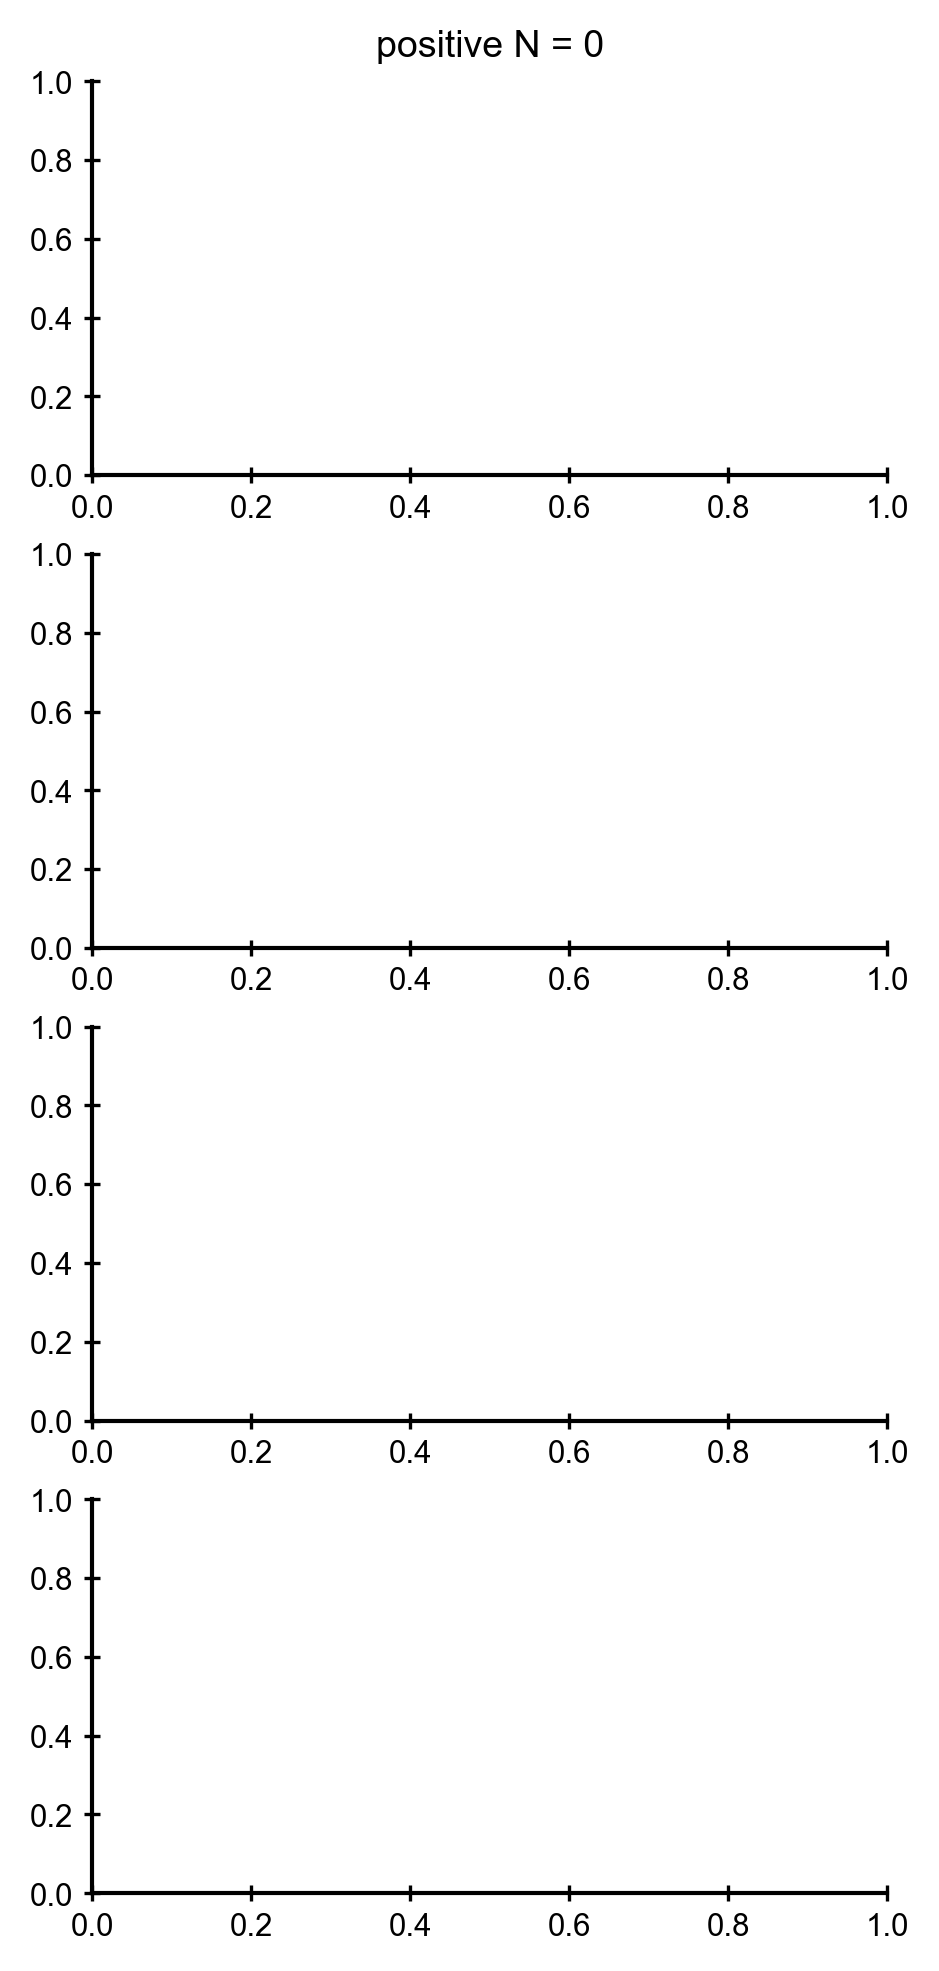

In [33]:
cases = [('positive', mask1),
         ('negative', mask2),
         ('pos infectious', mask3),
         ('pos cancer', mask6),
        ]
fig, axes = plt.subplots(figsize=(3.42, 2.0*len(cases)), nrows=len(cases), sharex=False)
for i, (name, mask) in enumerate(cases):
    print(name)
    ax = axes[i]
    d = df_t[mask]
    d0 = d['Epitope', 'Description'].apply(lambda x: x in human9)
    count0 = np.sum(d0)
    count1 = np.sum(d['Epitope', 'Description'].apply(lambda x: dist1(x, human9)) & (~d0))
    print(count0, count1)
    ax.axvline(count1/d.shape[0], c='k')
    ax.set_title(name + ' N = %g' % d.shape[0])
    xmax = 0.05
    x = np.arange(0, xmax*d.shape[0])
    Ncomp = d.shape[0]*Nhuman
    mu = Ncomp*n0
    ax.plot(x/d.shape[0], poisson.pmf(x, mu), '-', ms=8, label='flat')
    mu = Ncomp*n
    ax.plot(x/d.shape[0], poisson.pmf(x, mu), '-', ms=8, label='independent')
    mu = Ncomp*ntri
    ax.plot(x/d.shape[0], poisson.pmf(x, mu), '-', ms=8, label='tri')
    ax.set_ylim(0.0)
    ax.set_xlim(0.0, xmax)
    ax.set_yticks([])
ax.set_xlabel('Peptides at distance 1 to self')
fig.tight_layout()

In [34]:
def nndist_probability(k, N):
    K = 20**k
    d = np.arange(0, k+1)
    Nc = lambda d: 19**d * falling_factorial(k, d+1)
    Ncs = Nc(d)
    cumulative = [0]
    cumulative.extend(1-np.exp(-np.cumsum(Ncs)*N/K))
    p = np.diff(cumulative)
    return d, p

In [35]:
human_9mers = np.array(list(human9))

In [36]:
def distance_distribution(sample, selfset):
    d0 = np.array([x in selfset for x in sample])
    count0 = np.sum(d0)
    d1 = np.array([dist1(x, selfset) for x in sample]) & (~d0)
    count1 = np.sum(d1)
    d2 = np.array([dist2(x, selfset) for x in sample]) & (~d1) & (~d0)
    count2 = np.sum(d2)
    ns = np.array([count0, count1, count2, len(sample)-count0-count1-count2])
    return ns

In [37]:
humansample = set(np.random.choice(human_9mers, 5000))
ns_self = distance_distribution(humansample, set(human9)-humansample)

In [39]:
pb1ufo = set(count_kmers_proteome(datadir + 'ufos/pb1ufo.fasta.gz', k))
ns_ufo = distance_distribution(pb1ufo, human9)

In [40]:
len(pb1ufo)

6732

In [41]:
frameshifts = set(count_kmers_proteome(datadir + 'cancer/frameshifts.fasta.gz', k))
len(frameshifts)

1466143

In [42]:
ns_frameshifts = distance_distribution(np.random.choice(np.array(list(frameshifts)), 5000), human9)

In [44]:
ns

array([  33,  120, 2734, 3784])

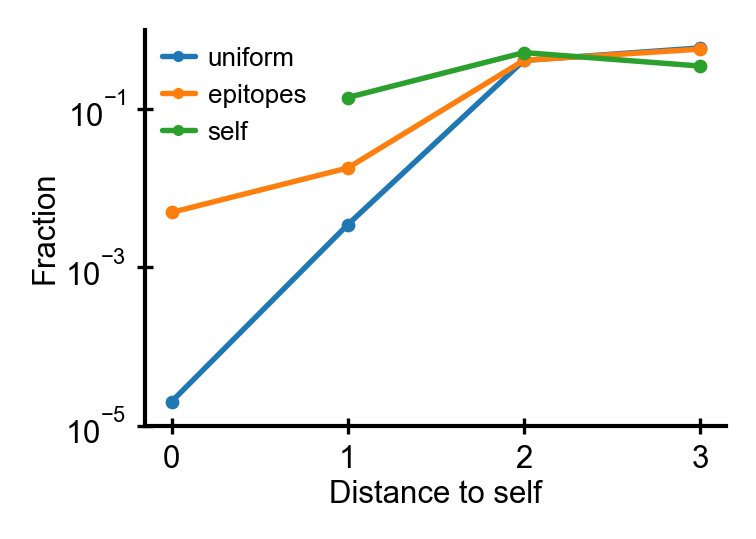

In [43]:
fig, ax = plt.subplots(figsize=(2.5, 1.75))
N = len(human9)
k = 9
d, p = nndist_probability(k, N)
ax.plot(d[:4], [p[0], p[1], p[2], np.sum(p[3:])], '-o', label='uniform')
ax.plot(range(4), ns/np.sum(ns), '-o', label='epitopes')
#ax.plot(range(4), ns_ufo/np.sum(ns_ufo), '-o', label='ufo')
#ax.plot(range(4), ns_frameshifts/np.sum(ns_frameshifts), '-o', label='frameshifts')
ax.plot(range(1, 4), ns_self[1:]/np.sum(ns_self[1:]), '-o', label='self')
#ax.plot([0, 1], [pptri*N, ntri*N], '-o')
ax.set_ylim(1e-5, 1)
ax.legend()
ax.set_yscale('log')
ax.set_ylabel('Fraction')
ax.set_xlabel('Distance to self')
fig.savefig('neighbors.svg')

# Analysis of flu epitopes

In [ ]:
fluepis = df_t[df_t['Epitope', 'Parent Species'] == 'Influenza A virus']#['Epitope', 'Description'].unique()
fluepis.shape

In [ ]:
fluepis['Epitope', 'Description'].unique().shape

In [ ]:
plt.hist([len(s) for s in fluepis['Epitope', 'Description'].unique()], bins=np.arange(8, 21))

In [ ]:
nchunks = 100
btdist = BallTreeDist(human9, nchunks=nchunks)

In [ ]:
fluepis9 = fluepis[fluepis['Epitope', 'Description'].apply(len)==9]
#list(fluepis9['Epitope', 'Description'].unique())

In [ ]:
fludists = [btdist.mindist(e) for e in list(fluepis9['Epitope', 'Description'].unique())]

In [ ]:
np.histogram(fludists, np.arange(0, 6))

In [ ]:
proteomes = load_proteomes()


In [ ]:
df_flua = counter_to_df(count_kmers_proteome(datadir + proteomes.loc['InfluenzaA']['path'], 9), norm=True)
df_flua.head()

In [ ]:
distss = []
for i in range(3):
    peptides = np.random.choice(df_flua['seq'], size=int(len(fludists)), replace=False, p=df_flua['freq'])
    dists = [btdist.mindist(e) for e in peptides]
    distss.append(dists)

In [ ]:
counts = np.bincount(fludists)
print(counts)
plt.plot(counts, 'o')
for d in [distss[0], distss[1], distss[2]]:
    counts = np.bincount(d)
    print(counts)
    plt.plot(counts, 'kx')

In [ ]:
def dists_direct(df, ref):
    d0 = df[df['seq'].apply(lambda x: x in ref)].shape[0]/df['seq'].shape[0]
    d1 = df[df['seq'].apply(dist1)].shape[0]/df['seq'].shape[0]
    d2 = df[df['seq'].apply(dist2)].shape[0]/df['seq'].shape[0]
    return d0, d1, d2

In [ ]:
distsallflu = dists_direct(df_flua, human9)

In [ ]:
counts = np.bincount(fludists)
plt.plot(counts/np.sum(counts), 'o')
plt.plot(distsallflu, 'x')

N = sum(counter9.values())
print('%e'%N)
k = 9
K = 20**k

dists = np.arange(6)
Nc = 19**dists * falling_factorial(k, dists+1)
cumulative = [0]
cumulative.extend(1-np.exp(-Nc*N/K))
plt.plot(dists, np.diff(cumulative), '+')
plt.ylim(0.0)

In [ ]:
hivepis = d[d['Epitope', 'Parent Species'] == 'Human immunodeficiency virus 1']['Epitope', 'Description'].unique()
hivepis.shape

In [ ]:
hivdists = [mindist_sklearn_chunked(e, bts) for e in hivepis]

In [ ]:
counts = np.bincount(hivdists)
print(counts)
plt.plot(counts, 'x')

In [ ]:
df_hiv1 = counter_to_df(count_kmers_proteome(datadir + proteomes.loc['HIV']['path'], 9), norm=True)
df_hiv1.head()

In [ ]:
distss_hiv = []
for i in range(3):
    peptides = np.random.choice(df_hiv1['seq'], size=len(hivdists), replace=False, p=df_hiv1['freq'])
    dists = [mindist_sklearn_chunked(e, bts) for e in peptides]
    distss_hiv.append(dists)

In [ ]:
counts = np.bincount(hivdists)
print(counts)
plt.plot(counts, 'o')
for d in distss_hiv:
    counts = np.bincount(d)
    print(counts)
    plt.plot(counts, 'kx')

In [ ]:
distsallhiv = dists_direct(df_hiv1, human9)

In [ ]:
counts = np.bincount(hivdists)
plt.plot(counts/np.sum(counts), 'o')
plt.plot(distsallhiv, 'x')
N = sum(counter9.values())
print('%e'%N)
k = 9
K = 20**k

dists = np.arange(6)
Nc = lambda d: 19**dists * falling_factorial(k, dists+1)
cumulative = [0]
cumulative.extend(1-np.exp(-Nc(dists)*N/K))
plt.plot(dists, np.diff(cumulative), '+')
plt.ylim(0.0)